In [1]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

# we first define the autoencoder's architecture:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

def Encoder():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    e2 = MaxPooling2D((2, 2), padding='same')(e1)
    e3 = Conv2D(8, (3, 3), activation='relu', padding='same')(e2)
    e4 = MaxPooling2D((2, 2), padding='same')(e3)
    e5 = Conv2D(8, (3, 3), activation='relu', padding='same')(e4)
    e6 = MaxPooling2D((2, 2), padding='same')(e5)
    return Model(input_img, e6)

def Decoder():
    input_img = Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    d2 = UpSampling2D((2, 2))(d1)
    d3 = Conv2D(8, (3, 3), activation='relu', padding='same')(d2)
    d4 = UpSampling2D((2, 2))(d3)
    d5 = Conv2D(16, (3, 3), activation='relu')(d4)
    d6 = UpSampling2D((2, 2))(d5)
    d7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d6)
    return Model(input_img, d7)

Using TensorFlow backend.


In [2]:
# define input to the model:
x = Input(shape=(28, 28, 1))

# make the model:
autoencoder = Model(x, Decoder()(Encoder()(x)))

# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
# SEE INSIDE THE ENCODER AND DECODER:
Encoder().summary()
Decoder().summary()

# IN FACT, OUT AUTOENCODER WILL BE A CONCATENATION OF TWO MODELS
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

In [4]:
# get the Dataset:

from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [5]:
# OR YOU CAN READ IN THE WHOLE MODEL WITH ITS WEIGHTS:
autoencoder = load_model('my_model.h5')

# OR YOU CAN FIRST DEFINE ANC COMPILE A MODEL, THEN READ IN ONLY THE WEIGHTS
# autoencoder.load_weights('my_model_weights.h5')

In [5]:
np.expand_dims(x_test[1000,], axis=0).shape

(1, 28, 28, 1)

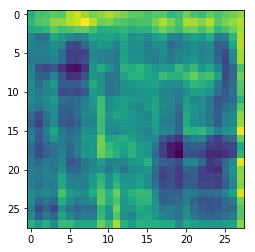

In [5]:
# Try if the pre-trained (or if you didn't load, a yet-untrained) model.
# If it shows nothing, then it's just not trained yet.

%matplotlib inline
pr = autoencoder.predict(np.expand_dims(x_test[1000,], axis=0)).reshape(28,28)
plt.imshow(pr)

In [6]:
# Training time!

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/home/amplifier/home/logs/ConvAutoMNIST')])

# save the entire model and the weights after the training:
autoencoder.save('my_model.h5')
autoencoder.save_weights('my_model_weights.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.2100 - val_loss: 0.1630
Epoch 2/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1519 - val_loss: 0.1392
Epoch 3/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1357 - val_loss: 0.1398
Epoch 4/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1280 - val_loss: 0.1250
Epoch 5/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1233 - val_loss: 0.1188
Epoch 6/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1203 - val_loss: 0.1197
Epoch 7/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1179 - val_loss: 0.1189
Epoch 8/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1161 - val_loss: 0.1150
Epoch 9/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1144 - val_loss: 0.1141
Epoch

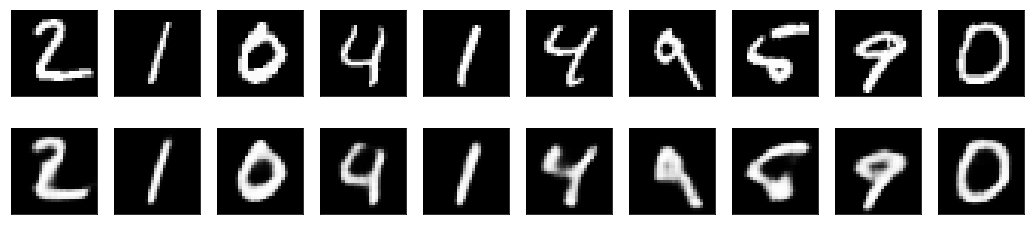

In [8]:
# now let's see how the model performs:

decoded_imgs = autoencoder.predict(x_test)

n = 11
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

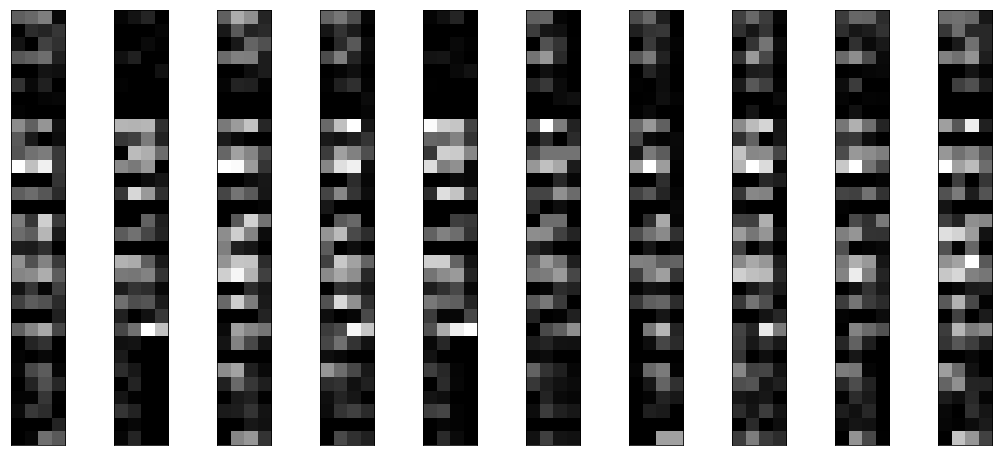

In [9]:
# See the hidden representations:

encoded_imgs = Encoder().predict(x_test)
n = 11
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(1, 4, 4, 8)
(1, 28, 28, 1)
(1, 28, 28, 1)


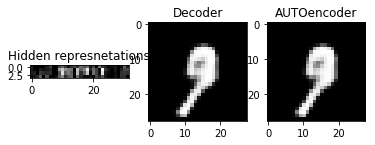

In [14]:
# NOW, let's use the hidden representations to reconstruct the figures:
# YOU COULD SLIGHTLY CHANGE THE HIDDEN REPRESENTATIONS AND SEE WHAT HAPPENS (for more see the notebook DenseAutoencoder)


%matplotlib inline
prediction1 = autoencoder.layers[1].predict(np.expand_dims(x_test[1000,], axis=0))
print(prediction1.shape)
ax = plt.subplot(1,3,1)
dump = ax.set_title("Hidden represnetations")
dump = ax.imshow(prediction1.reshape(4, 4*8))

ax2 = plt.subplot(1,3,2)
prediction2 = autoencoder.layers[2].predict(prediction1)
print(prediction2.shape)
dump = ax2.imshow(prediction2.reshape(28,28))
dump = ax2.set_title('Decoder')

ax3 = plt.subplot(1,3,3)
prediction3 = autoencoder.predict(np.expand_dims(x_test[1000,], axis=0))
print(prediction3.shape)
dump = ax3.imshow(prediction3.reshape(28,28))
dump = ax3.set_title('AUTOencoder')


In [15]:
from tkinter import *

canvas_width = 500
canvas_height = 150

def paint( event ):
   python_green = "#476042"
   x1, y1 = ( event.x - 1 ), ( event.y - 1 )
   x2, y2 = ( event.x + 1 ), ( event.y + 1 )
   w.create_oval( x1, y1, x2, y2, fill = python_green )

master = Tk()
master.title( "Painting using Ovals" )
w = Canvas(master, 
           width=canvas_width, 
           height=canvas_height)
w.pack(expand = YES, fill = BOTH)
w.bind( "<B1-Motion>", paint )

message = Label( master, text = "Press and Drag the mouse to draw" )
message.pack( side = BOTTOM )
    
mainloop()

TclError: couldn't connect to display ":1"